In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import glob

import matplotlib.pyplot as plt

In [10]:
# Dictionary to hold dataframes grouped by both strategies
dict_df = defaultdict(list)

# Read all request stats files
for file in glob.glob("../output/request_stats_*.csv"):
    # Extract strategies from file name
    # Example filename: request_stats_AllOnStrategy_TimeGreedy_56.csv
    parts = file.split("_")
    power_strategy = parts[2]
    assignment_strategy = parts[3]
    user_count = int(parts[4].replace(".csv", ""))

    # Create a combined strategy key
    strategy_key = f"{power_strategy} + {assignment_strategy}"

    # Read the file into a DataFrame
    request_stats = pd.read_csv(file)

    # Store the data grouped by combined strategies
    dict_df[strategy_key].append(
        {
            "user_count": user_count,
            "power_strategy": power_strategy,
            "assignment_strategy": assignment_strategy,
            "data": request_stats,
        }
    )

In [11]:
def analyze_strategy(
    dict_df, power_strategy=None, assignment_strategy=None, graph_type="success_rate"
):
    """
    Analyze strategy-specific metrics or generate plots.

    Parameters:
        dict_df (defaultdict): Dictionary containing strategy data.
        power_strategy (list or str): The power strategy or list of strategies to analyze (default: None for all).
        assignment_strategy (list or str): The assignment strategy or list of strategies to analyze (default: None for all).
        graph_type (str): Type of graph to generate ("success_rate", "requests_per_user", or "box_plot").
    """
    # Ensure power_strategy and assignment_strategy are lists for uniform processing
    if isinstance(power_strategy, str):
        power_strategy = [power_strategy]
    if isinstance(assignment_strategy, str):
        assignment_strategy = [assignment_strategy]

    # Filter data by strategies
    filtered_data = {
        strategy_key: data
        for strategy_key, data in dict_df.items()
        if (not power_strategy or any(ps in strategy_key for ps in power_strategy))
        and (
            not assignment_strategy
            or any(as_ in strategy_key for as_ in assignment_strategy)
        )
    }

    if graph_type == "success_rate":
        plt.figure(figsize=(10, 6))

        # Define different line styles and markers
        line_styles = [
            ("solid", "o"),
            ("dashed", "s"),
            ("dashdot", "^"),
            ("dotted", "D"),
            ("-", "v"),
            ("--", "p"),
        ]

        for idx, (strategy_key, data) in enumerate(filtered_data.items()):
            user_counts = []
            success_rates = []

            for entry in data:
                request_stats = entry["data"]
                completed_requests = request_stats[
                    request_stats["status"] == "RequestStatus.COMPLETED"
                ].shape[0]
                failed_requests = request_stats[
                    request_stats["status"] == "RequestStatus.FAILED"
                ].shape[0]

                total_requests = completed_requests + failed_requests
                success_rate = (
                    (completed_requests / total_requests * 100)
                    if total_requests > 0
                    else 0
                )

                user_counts.append(entry["user_count"])
                success_rates.append(success_rate)

            # Sort the data
            sorted_data = sorted(zip(user_counts, success_rates))
            user_counts, rates = zip(*sorted_data)

            # Use different line style and marker for each line
            line_style, marker = line_styles[idx % len(line_styles)]
            plt.plot(
                user_counts,
                rates,
                linestyle=line_style,
                marker=marker,
                markersize=8,
                label=strategy_key,
            )

        plt.title("Success Rate vs Users")
        plt.xlabel("Number of Users")
        plt.ylabel("Success Rate (%)")
        plt.ylim(0, 110)
        plt.grid(True)
        plt.legend(title="Strategies", bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()  # Adjust layout to prevent legend cutoff
        plt.show()

    elif graph_type == "requests_per_user":
        plt.figure(figsize=(10, 6))

        # Define different line styles and markers
        line_styles = [
            ("solid", "o"),
            ("dashed", "s"),
            ("dashdot", "^"),
            ("dotted", "D"),
            ("-", "v"),
            ("--", "p"),
        ]

        for idx, (strategy_key, data) in enumerate(filtered_data.items()):
            user_counts = []
            requests_per_user = []

            for entry in data:
                request_stats = entry["data"]
                total_requests = len(request_stats)
                user_counts.append(entry["user_count"])
                requests_per_user.append(total_requests / entry["user_count"])

            sorted_data = sorted(zip(user_counts, requests_per_user))
            user_counts, requests = zip(*sorted_data)

            # Use different line style and marker for each line
            line_style, marker = line_styles[idx % len(line_styles)]
            plt.plot(
                user_counts,
                requests,
                linestyle=line_style,
                marker=marker,
                markersize=8,
                label=strategy_key,
            )

        plt.title("Requests per User")
        plt.xlabel("Number of Users")
        plt.ylabel("Average Requests per User")
        plt.grid(True)
        plt.legend(title="Strategies", bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()  # Adjust layout to prevent legend cutoff
        plt.show()

    elif graph_type == "box_plot":
        power_strategies = defaultdict(list)
        for strategy_key, data in filtered_data.items():
            power_strat = strategy_key.split(" + ")[0]
            for entry in data:
                request_stats = entry["data"]
                completed = request_stats[
                    request_stats["status"] == "RequestStatus.COMPLETED"
                ].shape[0]
                failed = request_stats[
                    request_stats["status"] == "RequestStatus.FAILED"
                ].shape[0]
                total = completed + failed
                success_rate = (completed / total * 100) if total > 0 else 0
                power_strategies[power_strat].append(success_rate)

        plt.figure(figsize=(10, 6))
        plt.boxplot(power_strategies.values(), labels=power_strategies.keys())
        plt.title("Success Rate Distribution by Power Strategy")
        plt.ylabel("Success Rate (%)")
        plt.ylim(0, 110)
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()  # Adjust layout to prevent label cutoff
        plt.show()

    else:
        print(
            "Unsupported graph type. Choose 'success_rate', 'requests_per_user', or 'box_plot'."
        )

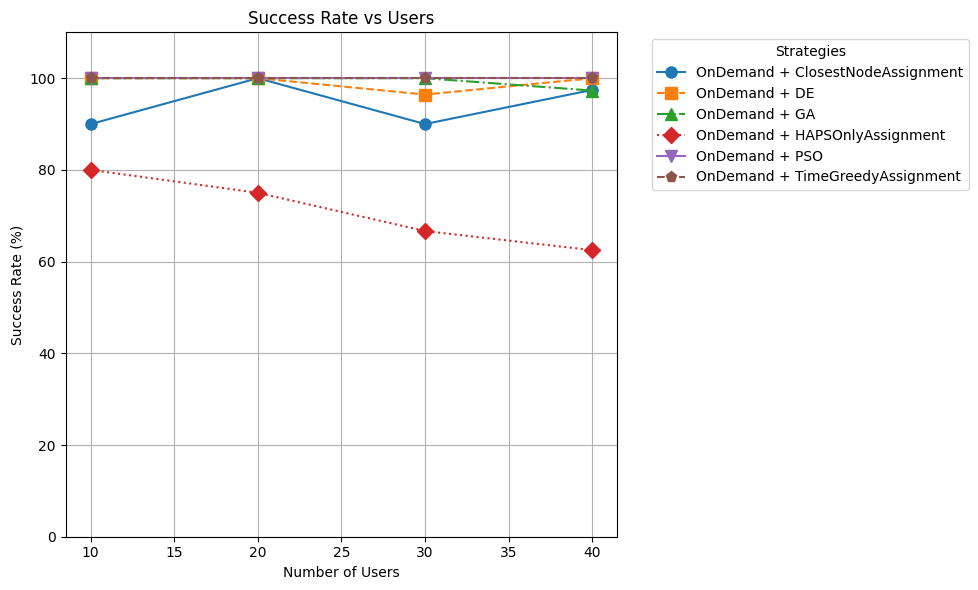

In [12]:
analyze_strategy(
    dict_df,
    assignment_strategy=["TimeGreedy", "ClosestNode", "HAPSOnly", "GA", "PSO", "DE"],
    power_strategy=["OnDemand"],
    graph_type="success_rate",
)